In [1]:
!pip install torch transformers pillow opencv-python easyocr scikit-learn matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 23.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
import os
import cv2
import easyocr
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import string
from google.colab import drive
drive.mount('/content/drive')

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 配置路径 - 请根据您的环境修改
# 路径配置
IMAGE_DIR = "/content/drive/MyDrive/Dissertation/images"
CSV_FILE = "/content/drive/MyDrive/Dissertation/labels.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Dissertation/"
CACHE_DIR = "/content/drive/MyDrive/Dissertation/cache"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive
使用设备: cuda


原始数据集大小: 6992
存在的图像文件: 6992
数据分布:
  训练集: 5593 样本
  验证集: 699 样本
  测试集: 700 样本
EasyOCR initialization successful


提取文本:  56%|█████▌    | 3135/5593 [11:37<09:37,  4.26张/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
提取文本:  57%|█████▋    | 3163/5593 [11:43<08:41,  4.66张/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
提取文本: 100%|██████████| 5593/5593 [20:39<00:00,  4.51张/s]


文本提取完成! 成功率: 5556/5593 (99.3%)
EasyOCR initialization successful


提取文本: 100%|██████████| 699/699 [02:39<00:00,  4.39张/s]


文本提取完成! 成功率: 695/699 (99.4%)
EasyOCR initialization successful


提取文本: 100%|██████████| 700/700 [02:35<00:00,  4.50张/s]


文本提取完成! 成功率: 695/700 (99.3%)
  Raw category counts: [ 121  384 1761 2501  826]
  Minority categories: [0 1 4]
  Enhanced weight: [3.39373633 1.06938046 0.02331869 0.01641912 0.4971454 ]


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


模型参数: 总计82,678,533, 可训练29,502,213

开始训练只使用文本的模型...
Category distribution statistics:
  Category 0 (very_negative): 3506
  Category 1 (negative): 3510
  Category 2 (neutral): 364
  Category 3 (positive): 362
  Category 4 (very_positive): 3444
CBFocalLoss settings:
  Number of samples per class: [3506 3510  364  362 3444]
  CB weights: [0.5324717  0.53216821 1.69626166 1.70185524 0.53724319]
  Alpha weights: [0.10325157 0.1031339  0.99450549 1.         0.10511034]

Epoch 1/20


Epoch 1 训练: 100%|██████████| 700/700 [01:36<00:00,  7.23batch/s, Loss=0.0940]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.89batch/s]



验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0084    0.1333    0.0159        15
     negative     0.0667    0.0208    0.0317        48
      neutral     0.3356    0.2273    0.2710       220
     positive     0.3571    0.0160    0.0306       313
very_positive     0.1373    0.3786    0.2016       103

     accuracy                         0.1388       699
    macro avg     0.1810    0.1552    0.1102       699
 weighted avg     0.2905    0.1388    0.1312       699


Epoch 1 结果:
训练损失: 0.2581
训练F1: 0.2698
训练Macro F1: 0.1930
验证损失: 1.4702
验证准确率: 0.1388 (13.88%)
验证F1: 0.1312
验证Macro F1: 0.1102
IMPROVING ★

Epoch 2/20


Epoch 2 训练: 100%|██████████| 700/700 [01:36<00:00,  7.23batch/s, Loss=0.0751]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.91batch/s]



验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0185    0.4667    0.0355        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3065    0.0864    0.1348       220
     positive     0.6667    0.0064    0.0127       313
very_positive     0.1331    0.3204    0.1880       103

     accuracy                         0.0873       699
    macro avg     0.2249    0.1760    0.0742       699
 weighted avg     0.4150    0.0873    0.0765       699


Epoch 2 结果:
训练损失: 0.2455
训练F1: 0.2686
训练Macro F1: 0.1924
验证损失: 1.5059
验证准确率: 0.0873 (8.73%)
验证F1: 0.0765
验证Macro F1: 0.0742
未改善 (1/6)

Epoch 3/20


Epoch 3 训练: 100%|██████████| 700/700 [01:36<00:00,  7.22batch/s, Loss=0.1120]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.95batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0199    0.4667    0.0383        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3095    0.0591    0.0992       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1433    0.4175    0.2134       103

     accuracy                         0.0901       699
    macro avg     0.0946    0.1886    0.0702       699
 weighted avg     0.1190    0.0901    0.0635       699


Epoch 3 结果:
训练损失: 0.2214
训练F1: 0.2778
训练Macro F1: 0.1961
验证损失: 1.5677
验证准确率: 0.0901 (9.01%)
验证F1: 0.0635
验证Macro F1: 0.0702
未改善 (2/6)

Epoch 4/20


Epoch 4 训练: 100%|██████████| 700/700 [01:37<00:00,  7.21batch/s, Loss=0.0777]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.96batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0160    0.3333    0.0305        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.6667    0.0091    0.0179       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1600    0.5825    0.2510       103

     accuracy                         0.0959       699
    macro avg     0.1685    0.1850    0.0599       699
 weighted avg     0.2337    0.0959    0.0433       699


Epoch 4 结果:
训练损失: 0.2179
训练F1: 0.2884
训练Macro F1: 0.1998
验证损失: 1.5771
验证准确率: 0.0959 (9.59%)
验证F1: 0.0433
验证Macro F1: 0.0599
未改善 (3/6)

Epoch 5/20


Epoch 5 训练: 100%|██████████| 700/700 [01:36<00:00,  7.22batch/s, Loss=0.0788]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.89batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0225    0.7333    0.0437        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3158    0.0545    0.0930       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1783    0.2718    0.2154       103

     accuracy                         0.0730       699
    macro avg     0.1033    0.2119    0.0704       699
 weighted avg     0.1262    0.0730    0.0620       699


Epoch 5 结果:
训练损失: 0.2163
训练F1: 0.2976
训练Macro F1: 0.2018
验证损失: 1.5074
验证准确率: 0.0730 (7.30%)
验证F1: 0.0620
验证Macro F1: 0.0704
未改善 (4/6)

Epoch 6/20


Epoch 6 训练: 100%|██████████| 700/700 [01:36<00:00,  7.22batch/s, Loss=0.0614]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.93batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0266    0.4667    0.0504        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3295    0.1318    0.1883       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1676    0.5534    0.2573       103

     accuracy                         0.1330       699
    macro avg     0.1048    0.2304    0.0992       699
 weighted avg     0.1290    0.1330    0.0983       699


Epoch 6 结果:
训练损失: 0.2064
训练F1: 0.3002
训练Macro F1: 0.2091
验证损失: 1.4966
验证准确率: 0.1330 (13.30%)
验证F1: 0.0983
验证Macro F1: 0.0992
未改善 (5/6)

Epoch 7/20


Epoch 7 训练: 100%|██████████| 700/700 [01:37<00:00,  7.22batch/s, Loss=0.0680]



验证中...


验证: 100%|██████████| 44/44 [00:02<00:00, 15.91batch/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


验证集分类报告:
               precision    recall  f1-score   support

very_negative     0.0258    0.6667    0.0496        15
     negative     0.0500    0.0208    0.0294        48
      neutral     0.2655    0.1364    0.1802       220
     positive     0.0000    0.0000    0.0000       313
very_positive     0.1910    0.3301    0.2420       103

     accuracy                         0.1073       699
    macro avg     0.1065    0.2308    0.1002       699
 weighted avg     0.1157    0.1073    0.0955       699


Epoch 7 结果:
训练损失: 0.2148
训练F1: 0.2983
训练Macro F1: 0.2120
验证损失: 1.4616
验证准确率: 0.1073 (10.73%)
验证F1: 0.0955
验证Macro F1: 0.1002
未改善 (6/6)

基于Macro F1的早停触发! 连续6轮未改善

训练结果已保存至: /content/drive/MyDrive/Dissertation/text_only_training_results.csv

加载最佳模型进行测试...
开始最终测试...


测试: 100%|██████████| 44/44 [00:02<00:00, 15.95batch/s]



=== 最终测试结果 (只使用文本) ===
测试准确率: 0.1614 (16.14%)
测试加权F1: 0.1533
测试宏平均F1: 0.1238

测试集详细分类报告:
               precision    recall  f1-score   support

very_negative     0.0212    0.3333    0.0398        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3200    0.2545    0.2835       220
     positive     0.4400    0.0351    0.0651       313
very_positive     0.1627    0.3942    0.2303       104

     accuracy                         0.1614       700
    macro avg     0.1888    0.2035    0.1238       700
 weighted avg     0.3219    0.1614    0.1533       700


生成文本注意力可视化...
处理样本 1...
save: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_1.png


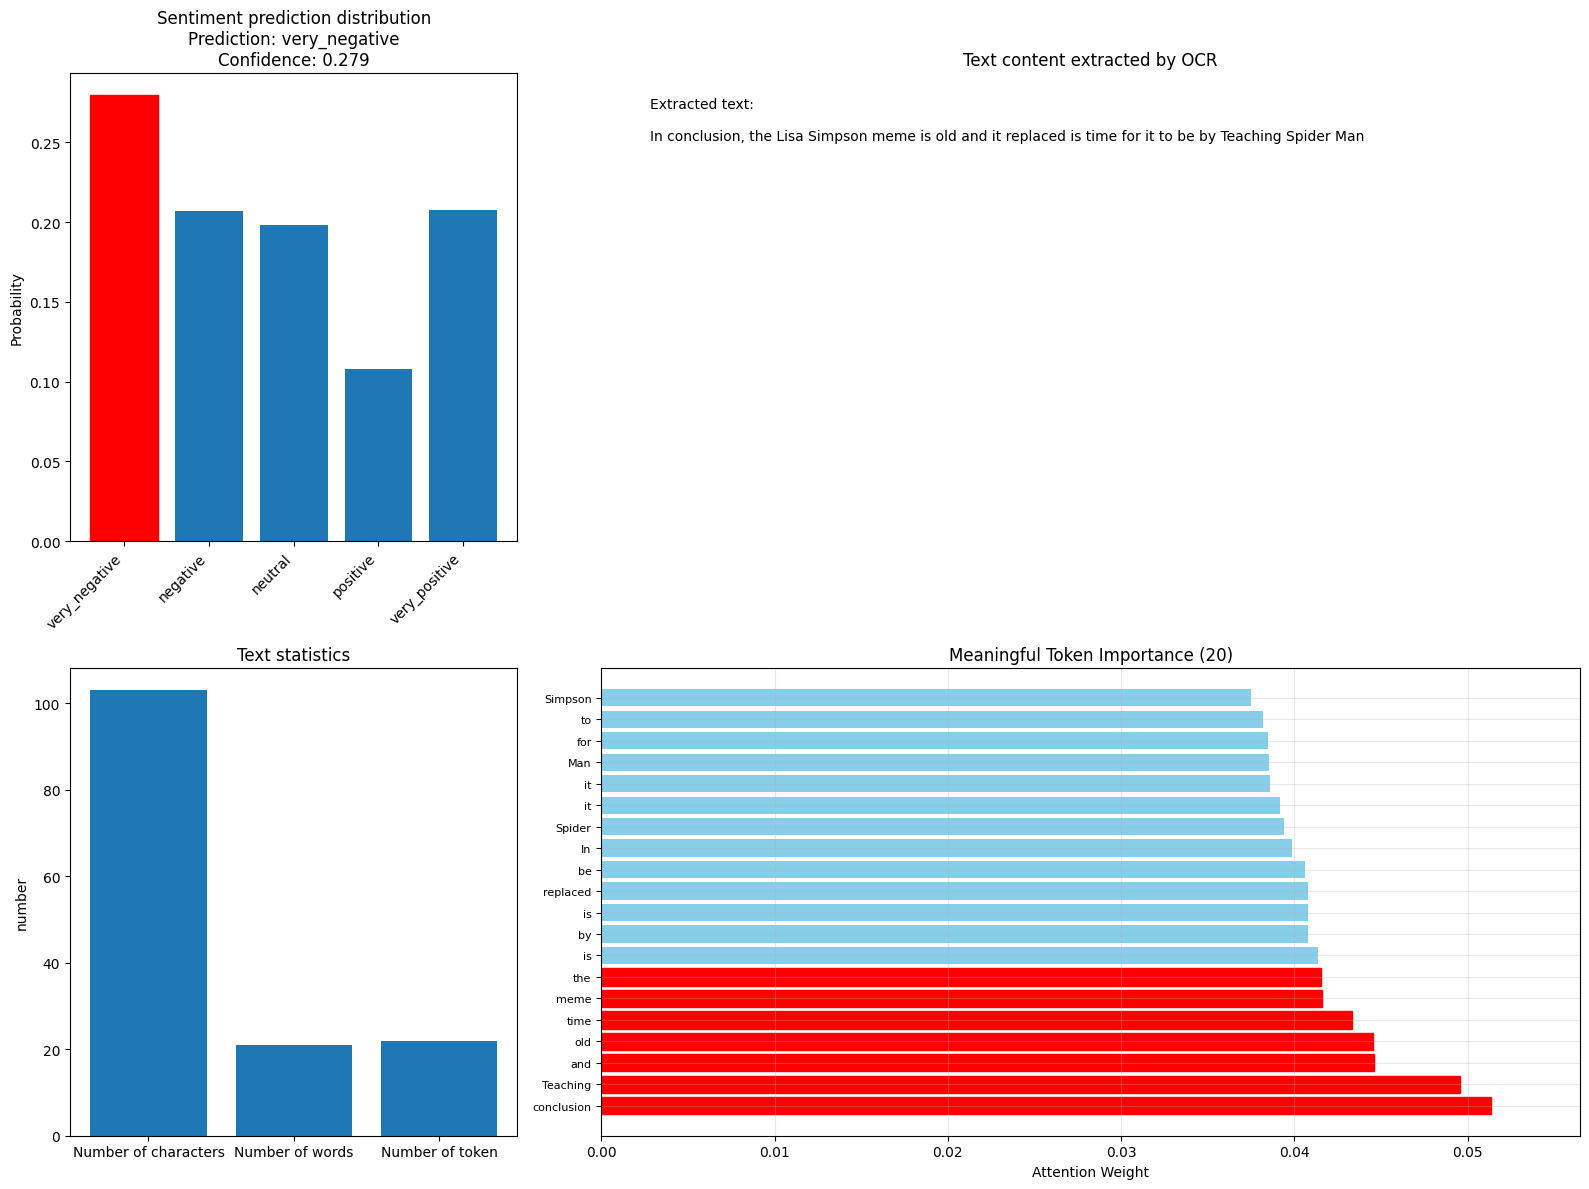

处理样本 2...
save: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_2.png


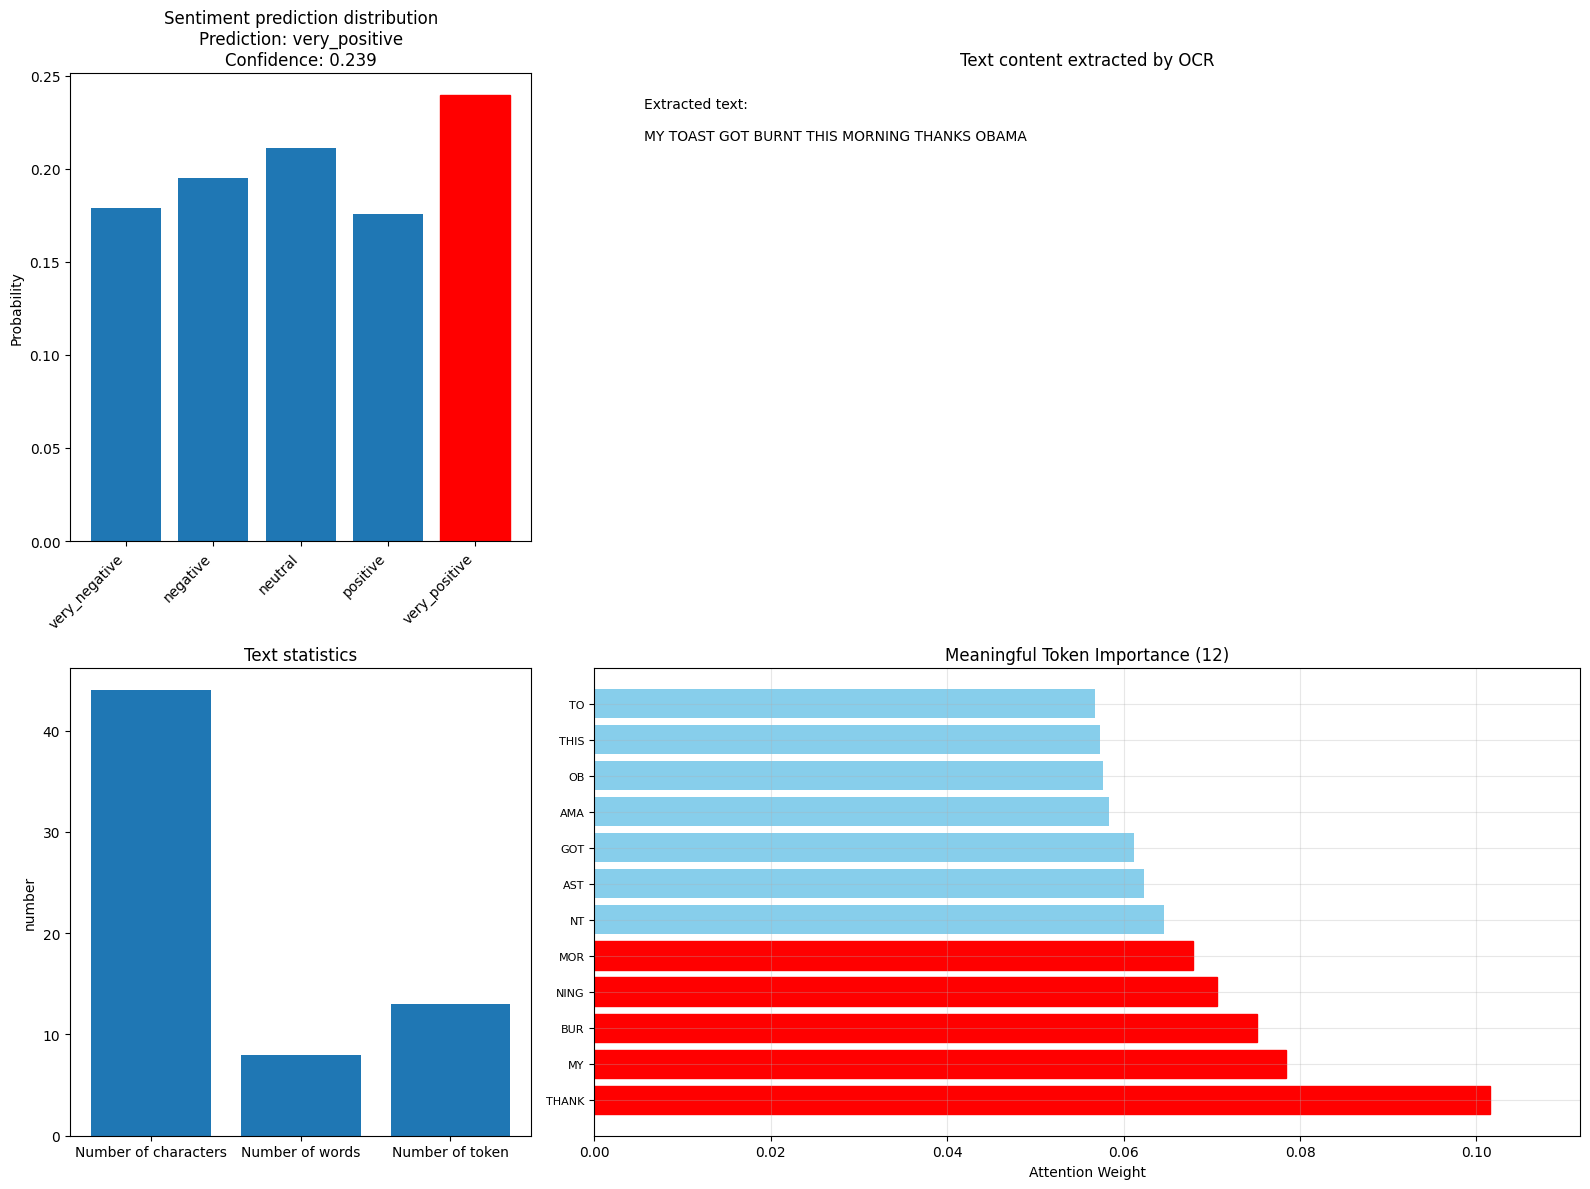

处理样本 3...
save: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_3.png


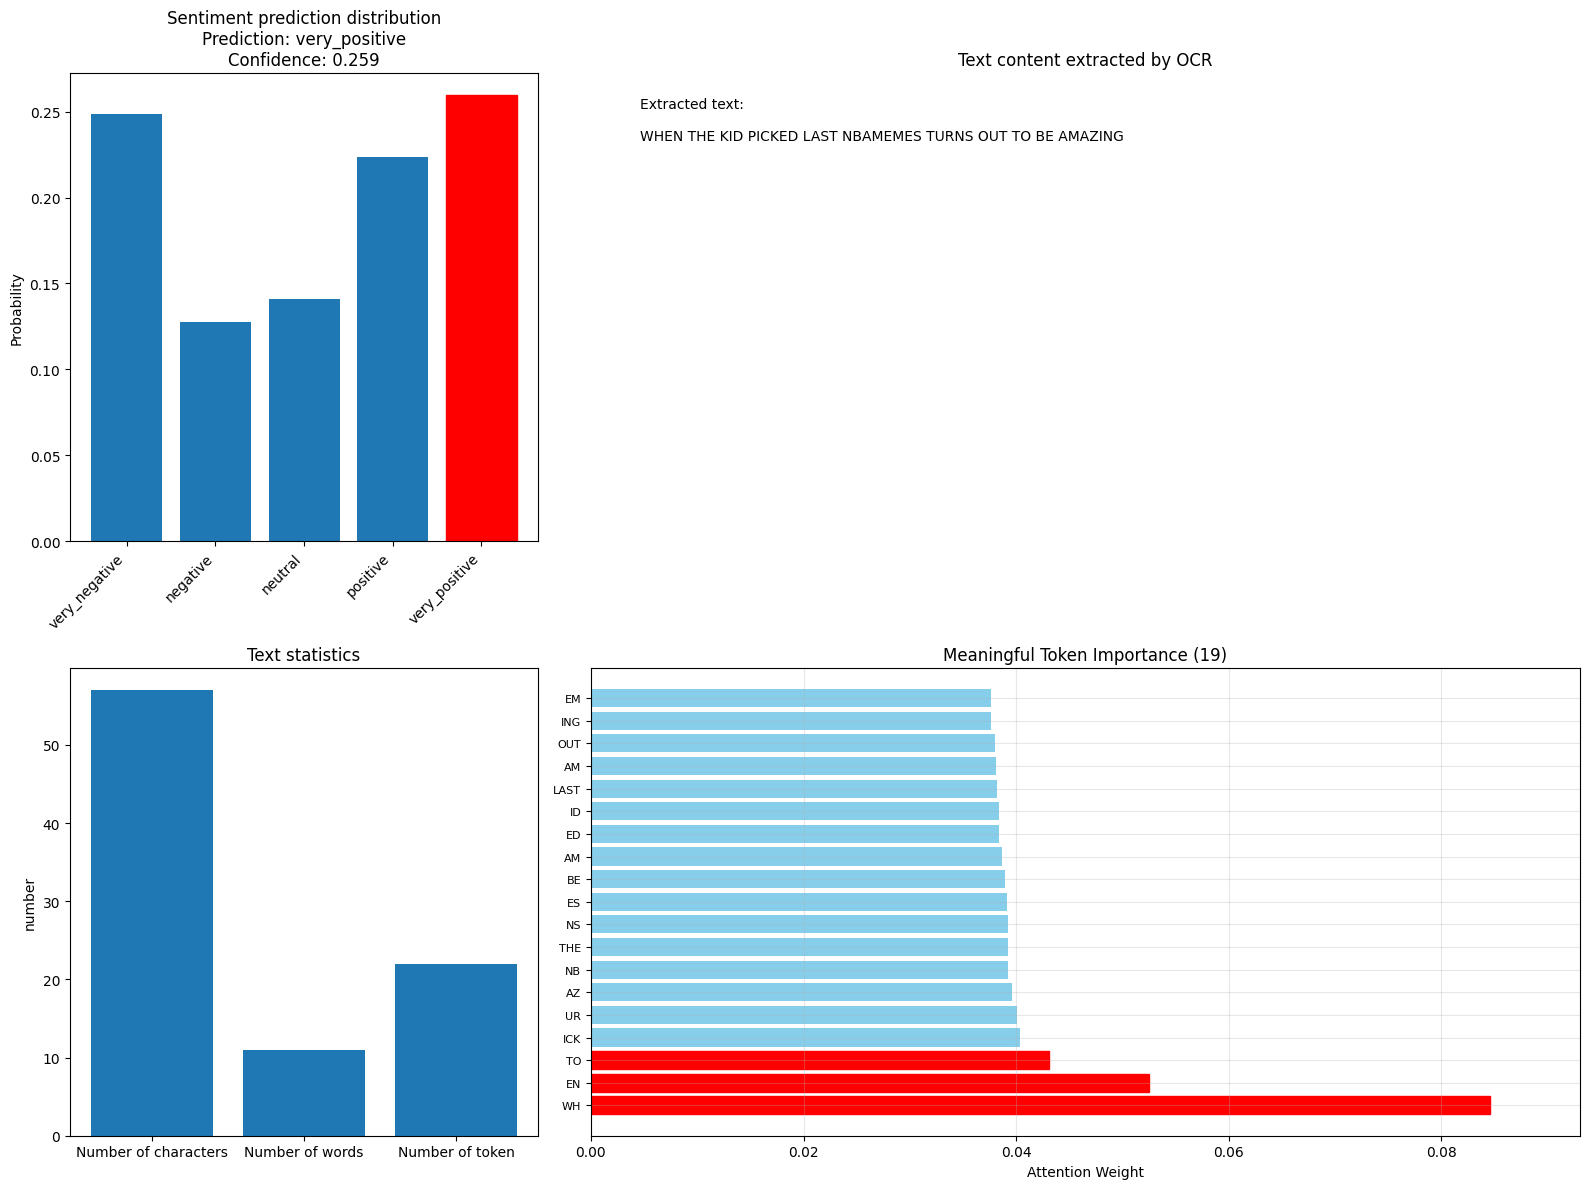

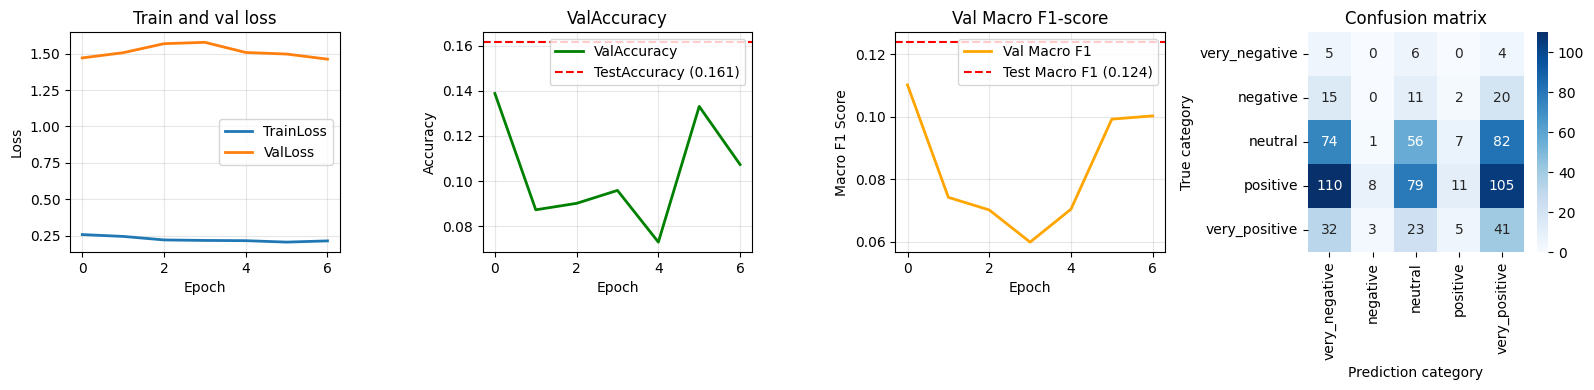


训练完成，文件保存路径: /content/drive/MyDrive/Dissertation/
最佳模型: /content/drive/MyDrive/Dissertation/best_text_only_model.pth
训练结果CSV: /content/drive/MyDrive/Dissertation/text_only_training_results.csv
测试结果CSV: /content/drive/MyDrive/Dissertation/text_only_test_results.csv
训练曲线图: /content/drive/MyDrive/Dissertation/text_only_training_analysis.png
注意力可视化: /content/drive/MyDrive/Dissertation/text_only_attention_visualization_sample_*.png
模型汇总: /content/drive/MyDrive/Dissertation/text_only_model_summary.csv


In [5]:
def clean_easyocr_text(text):
    """清理EasyOCR的输出文本"""
    if not text:
        return ""

    text = text.strip()
    text = re.sub(r'[^\w\s.,!?;:()\'-]', ' ', text)
    text = ' '.join(text.split())

    if len(text) < 2 or not any(c.isalpha() for c in text):
        return ""

    return text

def extract_text_with_easyocr(image_path, reader):
    """使用EasyOCR提取meme图像文本"""
    try:
        results = reader.readtext(image_path)
        if not results:
            return ""

        sorted_results = sorted(results, key=lambda x: x[0][0][1])
        texts = []
        for bbox, text, confidence in sorted_results:
            if confidence > 0.5:
                cleaned_text = clean_easyocr_text(text)
                if cleaned_text and len(cleaned_text) > 1:
                    texts.append(cleaned_text)

        return ' '.join(texts) if texts else ""

    except Exception as e:
        print(f"EasyOCR处理 {os.path.basename(image_path)} 时出错: {str(e)}")
        return ""

def extract_with_preprocessing(image_path, reader):
    """对图像进行预处理后使用EasyOCR"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return ""

        height, width = img.shape[:2]
        if min(height, width) < 500:
            scale = 500 / min(height, width)
            new_width = int(width * scale)
            new_height = int(height * scale)
            img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

        results = reader.readtext(enhanced)
        texts = []
        for bbox, text, confidence in results:
            if confidence > 0.3:
                cleaned_text = clean_easyocr_text(text)
                if cleaned_text and len(cleaned_text) > 1:
                    texts.append(cleaned_text)

        if results:
            sorted_results = sorted(
                [(bbox, text, conf) for bbox, text, conf in results if conf > 0.3],
                key=lambda x: x[0][0][1]
            )
            texts = [clean_easyocr_text(text) for bbox, text, conf in sorted_results
                    if clean_easyocr_text(text) and len(clean_easyocr_text(text)) > 1]

        return ' '.join(texts) if texts else ""

    except Exception as e:
        return ""

def extract_meme_text(image_path, reader):
    """组合多种方法提取meme文本"""
    text1 = extract_text_with_easyocr(image_path, reader)
    text2 = extract_with_preprocessing(image_path, reader)

    if len(text2) > len(text1) and len(text2) > 5:
        return text2
    elif len(text1) > 5:
        return text1
    else:
        return text2 if len(text2) > len(text1) else text1

class TextOnlyDataset(Dataset):
    """只使用文本的数据集"""
    def __init__(self, image_paths, labels, tokenizer, max_length=256):
        self.image_paths = image_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # 初始化EasyOCR读取器
        try:
            self.ocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
            print("EasyOCR initialization successful")
        except Exception as e:
            print(f"EasyOCR initialization error: {e}")
            raise

        # 预提取所有文本
        self.cached_texts = {}

        for i, path in enumerate(tqdm(image_paths, desc="提取文本", unit="张")):
            self.cached_texts[path] = self.extract_text_from_image(path)

        success_count = sum(1 for text in self.cached_texts.values()
                          if text and text not in ["[NO_TEXT_FOUND]", "[OCR_ERROR]"])
        print(f"文本提取完成! 成功率: {success_count}/{len(image_paths)} ({success_count/len(image_paths)*100:.1f}%)")

    def extract_text_from_image(self, image_path):
        """使用EasyOCR从图像中提取文本"""
        try:
            extracted_text = extract_meme_text(image_path, self.ocr_reader)

            if extracted_text:
                extracted_text = extracted_text.replace('\n', ' ').replace('\t', ' ')
                extracted_text = ' '.join(extracted_text.split())

            return extracted_text.strip() if extracted_text and extracted_text.strip() else "[NO_TEXT_FOUND]"

        except Exception as e:
            print(f"OCR提取完全失败 {image_path}: {e}")
            return "[OCR_ERROR]"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # 获取缓存的文本
        text = self.cached_texts.get(image_path, "[NO_TEXT]")

        # 简单的文本增强
        try:
            if isinstance(text, str) and len(text.split()) > 3:
                if random.random() < 0.2:
                    words = text.split()
                    keep = []
                    for w in words:
                        if random.random() < 0.95:
                            keep.append(w)
                    new_text = ' '.join(keep).strip()
                    if len(new_text) >= 2:
                        text = new_text
        except Exception:
            pass

        # 文本编码
        text_encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'text_input_ids': text_encoding['input_ids'].squeeze(),
            'text_attention_mask': text_encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
            'text': text,
            'image_path': image_path
        }

class CBFocalLoss(nn.Module):
    """类平衡Focal Loss"""
    def __init__(self, samples_per_class, num_classes, beta=0.99, gamma=2.5, alpha=None, reduction='mean'):
        super(CBFocalLoss, self).__init__()
        samples_per_class = np.maximum(samples_per_class, 1)

        effective_num = 1.0 - np.power(beta, samples_per_class)
        weights = (1.0 - beta) / effective_num

        min_samples = np.min(samples_per_class)
        max_samples = np.max(samples_per_class)
        ratio = max_samples / (samples_per_class + 1e-6)

        combined_weights = weights * (ratio ** 0.5)
        combined_weights = combined_weights / np.sum(combined_weights) * num_classes

        self.class_weights = torch.tensor(combined_weights, dtype=torch.float32)
        self.num_classes = num_classes
        self.gamma = gamma
        self.reduction = reduction

        if alpha is None:
            inv_freq = 1.0 / (samples_per_class + 1e-6)
            alpha = inv_freq / inv_freq.sum()
            alpha = alpha / alpha.max()

        self.alpha = torch.tensor(alpha, dtype=torch.float32)

        print(f"CBFocalLoss settings:")
        print(f"  Number of samples per class: {samples_per_class}")
        print(f"  CB weights: {combined_weights}")
        print(f"  Alpha weights: {alpha}")

    def forward(self, logits, labels):
        device = logits.device
        weights = self.class_weights.to(device)
        alpha = self.alpha.to(device)

        log_probs = F.log_softmax(logits, dim=1)
        ce_loss = F.nll_loss(log_probs, labels, reduction='none')

        probs = torch.exp(log_probs)
        pt = probs.gather(1, labels.unsqueeze(1)).squeeze(1)
        pt = torch.clamp(pt, min=1e-7, max=1.0)

        focal_term = (1 - pt) ** self.gamma
        alpha_t = alpha[labels]
        cb_weights = weights[labels]

        loss = alpha_t * cb_weights * focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class TextOnlyClassifier(nn.Module):
    """只使用文本的情感分类器"""
    def __init__(self, num_classes=5, hidden_dim=256):
        super(TextOnlyClassifier, self).__init__()

        # 文本编码器
        emotion_model_name = 'j-hartmann/emotion-english-distilroberta-base'
        try:
            self.text_encoder = AutoModel.from_pretrained(emotion_model_name)
            self.tokenizer_type = 'emotion-specific'
        except:
            self.text_encoder = AutoModel.from_pretrained('roberta-base')
            self.tokenizer_type = 'roberta'

        self.text_dim = self.text_encoder.config.hidden_size

        # 冻结部分层
        self._freeze_layers()

        # 分类网络
        self.classifier = nn.Sequential(
            nn.Linear(self.text_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim // 4, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def _freeze_layers(self):
        """冻结预训练模型的早期层"""
        for param in self.text_encoder.embeddings.parameters():
            param.requires_grad = False

        if hasattr(self.text_encoder, 'encoder'):
            total_layers = len(self.text_encoder.encoder.layer)
            freeze_layers = min(8, max(total_layers - 4, 0))
            for layer in self.text_encoder.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, text_input_ids, text_attention_mask):
        # 处理RoBERTa特殊token
        if self.tokenizer_type == 'roberta':
            text_input_ids = text_input_ids.masked_fill(text_input_ids == 1, 0)

        # 文本编码
        text_outputs = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            output_attentions=True
        )

        text_embeddings = text_outputs.last_hidden_state
        text_mask = text_attention_mask.unsqueeze(-1).expand(text_embeddings.size()).float()
        text_features = (text_embeddings * text_mask).sum(1) / text_mask.sum(1)

        # 分类
        logits = self.classifier(text_features)

        # 获取注意力权重用于可视化
        text_attentions = text_outputs.attentions
        if text_attentions and len(text_attentions) > 0:
            last_layer_attention = text_attentions[-1]
            avg_attention = last_layer_attention.mean(dim=1)
            cls_attention = avg_attention[:, 0, :]

            masked_attention = cls_attention * text_attention_mask.float()

            for i in range(masked_attention.size(0)):
                valid_positions = text_attention_mask[i].bool()
                if valid_positions.sum() > 1:
                    valid_attn = masked_attention[i][valid_positions]
                    if valid_attn.max() > valid_attn.min():
                        enhanced_attn = torch.softmax(valid_attn * 2.5, dim=0)
                        masked_attention[i][valid_positions] = enhanced_attn

            text_attn_weights = masked_attention
        else:
            text_attn_weights = None

        return logits, text_attn_weights

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        return self.counter >= self.patience

    def save_checkpoint(self, model):
        if self.restore_best_weights:
            self.best_weights = copy.deepcopy(model.state_dict())

    def restore(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def calculate_class_distribution(labels, num_classes=5):
    class_counts = np.bincount(labels, minlength=num_classes)
    samples_per_class = class_counts[:num_classes]

    print(f"Category distribution statistics:")
    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i, count in enumerate(samples_per_class):
        print(f"  Category {i} ({emotion_labels[i]}): {count}")

    return samples_per_class

def create_balanced_sampler(labels, minority_oversample_factor=8):
    labels = np.array(labels)
    class_counts = np.bincount(labels, minlength=5)

    minority_threshold = 900
    minority_classes = np.where(class_counts < minority_threshold)[0]

    base_weights = 1.0 / (class_counts + 1e-6)
    enhanced_weights = base_weights.copy()

    for cls_idx in minority_classes:
        enhanced_weights[cls_idx] *= minority_oversample_factor

    enhanced_weights = enhanced_weights / enhanced_weights.sum() * len(enhanced_weights)
    sample_weights = [enhanced_weights[label] for label in labels]

    print(f"  Raw category counts: {class_counts}")
    print(f"  Minority categories: {minority_classes}")
    print(f"  Enhanced weight: {enhanced_weights}")

    return sample_weights

def is_meaningful_token(token, min_length=2):
    """判断token是否有意义"""
    clean_token = token.replace('Ġ', '').replace('##', '').strip()

    if not clean_token or len(clean_token) < min_length:
        return False

    if clean_token in {'<s>', '</s>', '<pad>', '<mask>', '[CLS]', '[SEP]', '<unk>'}:
        return False

    if all(c in string.punctuation for c in clean_token):
        return False

    if not any(c.isalpha() for c in clean_token):
        return False

    return True

def visualize_text_attention(model, sample_data, tokenizer, save_path=None):
    """文本注意力可视化"""
    model.eval()

    with torch.no_grad():
        logits, text_attn_weights = model(
            text_input_ids=sample_data['text_input_ids'].unsqueeze(0).to(device),
            text_attention_mask=sample_data['text_attention_mask'].unsqueeze(0).to(device)
        )

        prediction = torch.argmax(logits, dim=1).cpu().item()
        confidence = torch.softmax(logits, dim=1).max().cpu().item()

    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    predicted_emotion = emotion_labels[prediction]

    fig = plt.figure(figsize=(16, 12))

    # 1. 情感分布
    ax1 = plt.subplot(2, 3, 1)
    probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    bars = ax1.bar(emotion_labels, probs)
    ax1.set_title(f'Sentiment prediction distribution\nPrediction: {predicted_emotion}\nConfidence: {confidence:.3f}')
    ax1.set_ylabel('Probability')
    plt.xticks(rotation=45, ha='right')
    bars[prediction].set_color('red')

    # 2. 提取的文本
    ax2 = plt.subplot(2, 3, (2, 3))
    text = sample_data['text']
    wrapped_text = text[:800] + "..." if len(text) > 800 else text
    ax2.text(0.05, 0.95, f"Extracted text:\n\n{wrapped_text}",
            fontsize=10, ha='left', va='top', wrap=True,
            transform=ax2.transAxes)
    ax2.set_title('Text content extracted by OCR', fontsize=12)
    ax2.axis('off')

    # 3. 文本长度统计
    ax3 = plt.subplot(2, 3, 4)
    input_ids = sample_data['text_input_ids'].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    valid_tokens = [t.replace('Ġ', ' ') for t in tokens if t not in ['<s>', '</s>', '<pad>']]
    text_stats = {
        'Number of characters': len(text),
        'Number of words': len(text.split()),
        'Number of token': len(valid_tokens)
    }
    bars = ax3.bar(text_stats.keys(), text_stats.values())
    ax3.set_title('Text statistics')
    ax3.set_ylabel('number')

    # 4. Token重要性分析
    ax4 = plt.subplot(2, 3, (5, 6))
    try:
        input_ids = sample_data['text_input_ids'].cpu().numpy()
        attention_mask = sample_data['text_attention_mask'].cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        if text_attn_weights is not None and text_attn_weights.numel() > 1:
            token_attention = text_attn_weights[0].cpu().numpy()

            meaningful_tokens = []
            valid_indices = np.where(attention_mask == 1)[0]

            for idx in valid_indices:
                if idx < len(tokens) and idx < len(token_attention):
                    token = tokens[idx]
                    weight = token_attention[idx]

                    if is_meaningful_token(token):
                        clean_token = token.replace('Ġ', '').replace('##', '').strip()
                        meaningful_tokens.append((idx, clean_token, float(weight)))

            if meaningful_tokens:
                meaningful_tokens.sort(key=lambda x: x[2], reverse=True)
                meaningful_tokens = meaningful_tokens[:20]  # 显示前20个

                indices, display_tokens, weights = zip(*meaningful_tokens)

                y_pos = np.arange(len(display_tokens))
                bars = ax4.barh(y_pos, weights, color='skyblue')
                ax4.set_yticks(y_pos)
                ax4.set_yticklabels(display_tokens, fontsize=8)
                ax4.set_xlabel('Attention Weight')
                ax4.set_title(f'Meaningful Token Importance ({len(meaningful_tokens)})')

                if len(weights) > 1:
                    mean_weight = np.mean(weights)
                    for i, weight in enumerate(weights):
                        if weight > mean_weight:
                            bars[i].set_color('red')

                ax4.set_xlim(0, max(weights) * 1.1)
            else:
                ax4.text(0.5, 0.5, 'No meaningful tokens found\nafter filtering',
                        ha='center', va='center')

        ax4.grid(True, alpha=0.3)

    except Exception as e:
        ax4.text(0.5, 0.5, f'Token analysis failed\n{str(e)[:50]}...',
                ha='center', va='center')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"save: {save_path}")
    plt.show()

def train_text_only_model(model, train_loader, val_loader, num_epochs=20, learning_rate=2e-5, save_dir=OUTPUT_DIR):
    """训练只使用文本的模型"""

    # 计算类别分布
    all_labels = []
    for batch in train_loader:
        all_labels.extend(batch['label'].tolist())
    samples_per_class = calculate_class_distribution(all_labels, num_classes=5)

    # 损失函数
    criterion = CBFocalLoss(
        samples_per_class=samples_per_class,
        num_classes=5,
        beta=0.99,
        gamma=2.5,
        alpha=None
    )

    # 优化器
    optimizer = optim.AdamW([
        {'params': model.text_encoder.parameters(), 'lr': learning_rate * 0.01, 'weight_decay': 1e-3},
        {'params': model.classifier.parameters(), 'lr': learning_rate, 'weight_decay': 2e-3}
    ], eps=1e-8, betas=(0.9, 0.999))

    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.8, patience=3, min_lr=1e-7
    )

    # 早停
    early_stopping = EarlyStopping(patience=6, min_delta=0.002)
    best_val_macro_f1 = 0
    patience = 6
    patience_counter = 0

    # 记录训练过程
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_macro_f1_scores = []
    training_results = []

    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # 训练阶段
        model.train()
        total_train_loss = 0
        all_train_predictions = []
        all_train_labels = []
        num_batches = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} 训练", unit="batch")

        for batch in train_pbar:
            optimizer.zero_grad()

            logits, _ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device)
            )
            labels = batch['label'].to(device)

            # 主损失
            loss = criterion(logits, labels)

            # L1正则化
            l1_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name and 'encoder' not in name:
                    l1_reg = l1_reg + torch.norm(param, 1)

            total_loss = loss + 1e-6 * l1_reg

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3)
            optimizer.step()

            total_train_loss += total_loss.item()
            num_batches += 1

            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_train_predictions.extend(predictions)
            all_train_labels.extend(labels_np)

            train_pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})

        # 计算训练指标
        avg_train_loss = total_train_loss / num_batches
        train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')
        train_macro_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')
        train_losses.append(avg_train_loss)

        # 验证阶段
        print("\n验证中...")
        model.eval()
        total_val_loss = 0
        all_val_predictions = []
        all_val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="验证", unit="batch"):
                logits, _ = model(
                    text_input_ids=batch['text_input_ids'].to(device),
                    text_attention_mask=batch['text_attention_mask'].to(device)
                )
                labels = batch['label'].to(device)
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                predictions = torch.argmax(logits, dim=1).cpu().numpy()
                labels_np = labels.cpu().numpy()
                all_val_predictions.extend(predictions)
                all_val_labels.extend(labels_np)

        # 计算验证指标
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_predictions)
        val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')
        val_macro_f1 = f1_score(all_val_labels, all_val_predictions, average='macro')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_macro_f1_scores.append(val_macro_f1)

        scheduler.step(val_macro_f1)

        # 生成验证集分类报告
        val_report = classification_report(all_val_labels, all_val_predictions,
                                         target_names=emotion_labels, digits=4)
        print(f"\n验证集分类报告:")
        print(val_report)

        # 检查改善情况
        improved = ""
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            patience_counter = 0
            improved = "IMPROVING ★"
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_text_only_model.pth'))
        else:
            patience_counter += 1
            improved = f"未改善 ({patience_counter}/{patience})"

        print(f"\nEpoch {epoch+1} 结果:")
        print(f"训练损失: {avg_train_loss:.4f}")
        print(f"训练F1: {train_f1:.4f}")
        print(f"训练Macro F1: {train_macro_f1:.4f}")
        print(f"验证损失: {avg_val_loss:.4f}")
        print(f"验证准确率: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"验证F1: {val_f1:.4f}")
        print(f"验证Macro F1: {val_macro_f1:.4f}")
        print(f"{improved}")

        # 保存训练结果
        training_results.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_f1': train_f1,
            'train_macro_f1': train_macro_f1,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_macro_f1': val_macro_f1,
            'best_val_macro_f1': best_val_macro_f1,
            'patience_counter': patience_counter,
            'improved': improved
        })

        # 早停检查
        if early_stopping(avg_val_loss, model):
            print(f"\n早停触发! 连续{early_stopping.patience}轮未改善")
            early_stopping.restore(model)
            break

        if patience_counter >= patience:
            print(f"\n基于Macro F1的早停触发! 连续{patience}轮未改善")
            break

    # 保存训练结果
    results_df = pd.DataFrame(training_results)
    results_csv_path = os.path.join(save_dir, 'text_only_training_results.csv')
    results_df.to_csv(results_csv_path, index=False)
    print(f"\n训练结果已保存至: {results_csv_path}")

    return train_losses, val_losses, val_accuracies, val_f1_scores, val_macro_f1_scores

def prepare_data(labels_csv_path, images_dir):
    df = pd.read_csv(labels_csv_path)
    print(f"原始数据集大小: {len(df)}")

    emotion_map = {
        'very_positive': 4,
        'positive': 3,
        'neutral': 2,
        'negative': 1,
        'very_negative': 0
    }

    df['emotion_id'] = df['overall_sentiment'].map(emotion_map)
    df['full_path'] = df['image_name'].apply(lambda x: os.path.join(images_dir, x))

    existing_files = df[df['full_path'].apply(os.path.exists)]
    print(f"存在的图像文件: {len(existing_files)}")

    return existing_files

def main():
    df = prepare_data(CSV_FILE, IMAGE_DIR)

    # 数据分割
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion_id'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion_id'])

    print(f"数据分布:")
    print(f"  训练集: {len(train_df)} 样本")
    print(f"  验证集: {len(val_df)} 样本")
    print(f"  测试集: {len(test_df)} 样本")

    # 初始化tokenizer
    try:
        tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')
    except:
        tokenizer = AutoTokenizer.from_pretrained('roberta-base')

    # 创建数据集
    train_dataset = TextOnlyDataset(
        train_df['full_path'].tolist(),
        train_df['emotion_id'].tolist(),
        tokenizer,
        max_length=256
    )

    val_dataset = TextOnlyDataset(
        val_df['full_path'].tolist(),
        val_df['emotion_id'].tolist(),
        tokenizer,
        max_length=256
    )

    test_dataset = TextOnlyDataset(
        test_df['full_path'].tolist(),
        test_df['emotion_id'].tolist(),
        tokenizer,
        max_length=256
    )

    # 创建采样器
    sample_weights = create_balanced_sampler(train_df['emotion_id'].tolist(), minority_oversample_factor=10)

    total_samples = len(train_df)
    num_samples_per_epoch = max(total_samples * 2, 8000)
    sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples_per_epoch, replacement=True)

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    # 初始化模型
    model = TextOnlyClassifier(num_classes=5, hidden_dim=512)
    model.to(device)

    # 计算模型参数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"模型参数: 总计{total_params:,}, 可训练{trainable_params:,}")

    # 训练模型
    print(f"\n开始训练只使用文本的模型...")
    train_losses, val_losses, val_accuracies, val_f1_scores, val_macro_f1_scores = train_text_only_model(
        model, train_loader, val_loader, num_epochs=20, learning_rate=2e-5
    )

    # 加载最佳模型进行测试
    print(f"\n加载最佳模型进行测试...")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_text_only_model.pth')))
    model.eval()

    # 测试评估
    all_test_predictions = []
    all_test_labels = []

    print("开始最终测试...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="测试", unit="batch"):
            logits, _ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device)
            )
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch['label'].cpu().numpy()

            all_test_predictions.extend(predictions)
            all_test_labels.extend(labels)

    # 计算最终指标
    test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')
    test_macro_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

    print(f"\n=== 最终测试结果 (只使用文本) ===")
    print(f"测试准确率: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"测试加权F1: {test_f1:.4f}")
    print(f"测试宏平均F1: {test_macro_f1:.4f}")

    # 详细分类报告
    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    test_report = classification_report(all_test_labels, all_test_predictions,
                                       target_names=emotion_labels, digits=4)
    print(f"\n测试集详细分类报告:")
    print(test_report)

    # 保存测试结果
    test_results = {
        'model_type': 'text_only',
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'test_macro_f1': test_macro_f1,
        'classification_report': test_report
    }

    test_results_df = pd.DataFrame([test_results])
    test_csv_path = os.path.join(OUTPUT_DIR, 'text_only_test_results.csv')
    test_results_df.to_csv(test_csv_path, index=False)

    # 生成文本注意力可视化
    print(f"\n生成文本注意力可视化...")
    for i in range(min(3, len(test_dataset))):
        sample_data = test_dataset[i]
        save_path = os.path.join(OUTPUT_DIR, f'text_only_attention_visualization_sample_{i+1}.png')
        print(f"处理样本 {i+1}...")
        visualize_text_attention(model, sample_data, tokenizer, save_path=save_path)

    # 绘制训练曲线和混淆矩阵
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.plot(train_losses, label='TrainLoss', linewidth=2)
    plt.plot(val_losses, label='ValLoss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and val loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 2)
    plt.plot(val_accuracies, label='ValAccuracy', color='green', linewidth=2)
    plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'TestAccuracy ({test_accuracy:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('ValAccuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 3)
    plt.plot(val_macro_f1_scores, label='Val Macro F1', color='orange', linewidth=2)
    plt.axhline(y=test_macro_f1, color='red', linestyle='--', label=f'Test Macro F1 ({test_macro_f1:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Val Macro F1-score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 混淆矩阵
    plt.subplot(1, 4, 4)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_test_labels, all_test_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion matrix')
    plt.xlabel('Prediction category')
    plt.ylabel('True category')

    plt.tight_layout()
    training_plot_path = os.path.join(OUTPUT_DIR, 'text_only_training_analysis.png')
    plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    # 创建最终汇总报告
    final_summary = {
        'model_name': 'Text Only Emotion Classifier',
        'total_params': total_params,
        'trainable_params': trainable_params,
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'final_test_accuracy': test_accuracy,
        'final_test_f1': test_f1,
        'final_test_macro_f1': test_macro_f1,
        'best_val_f1': max(val_f1_scores) if val_f1_scores else 0,
        'epochs_trained': len(train_losses),
        'ocr_method': 'EasyOCR',
        'text_encoder': 'j-hartmann/emotion-english-distilroberta-base'
    }

    summary_df = pd.DataFrame([final_summary])
    summary_csv_path = os.path.join(OUTPUT_DIR, 'text_only_model_summary.csv')
    summary_df.to_csv(summary_csv_path, index=False)

    print(f"\n训练完成，文件保存路径: {OUTPUT_DIR}")
    print(f"最佳模型: {OUTPUT_DIR}best_text_only_model.pth")
    print(f"训练结果CSV: {OUTPUT_DIR}text_only_training_results.csv")
    print(f"测试结果CSV: {OUTPUT_DIR}text_only_test_results.csv")
    print(f"训练曲线图: {OUTPUT_DIR}text_only_training_analysis.png")
    print(f"注意力可视化: {OUTPUT_DIR}text_only_attention_visualization_sample_*.png")
    print(f"模型汇总: {OUTPUT_DIR}text_only_model_summary.csv")

if __name__ == "__main__":
    main()